### Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib 
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, GRU, TimeDistributed, Input, Conv1D, Concatenate, Flatten, Lambda, Reshape
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras.backend as K
import _pickle as pickle
from scipy.io import loadmat
from numpy.linalg import inv
import itertools
%matplotlib inline

import matplotlib.font_manager as font_manager

font_dirs = ['/home/eevee/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 16

Using TensorFlow backend.


### Loading Data

In [2]:
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def get_valid_RVEs(data):
    valid_rves = []
    for rve in data.keys():
        ener = data['RVE'+rve[3:]]['Sample1']['BC'+rve[3:]]['ELPD']
        if ener.shape[0]==101:
            valid_rves.append(rve[3:])
    return valid_rves

def mon_increase_error(data):
    total_error = 0.0
    for ind in range(data.shape[0]-1):
        if data[ind]-data[ind+1] > 0.0:
            total_error += data[ind]-data[ind+1]
    return total_error

In [3]:
data_list = ['RVEs_postprocessing_variables_yoda.p', 
             'RVEs_postprocessing_variables_anakin.p',
             'RVEs_postprocessing_variables_leonidas.p',
            ]

data = {}
for file in data_list:
    with open('Data/'+file, 'rb') as file:
        data_local = pickle.load(file , encoding='latin1')
        data.update(data_local)
        
DOE = loadmat('Data/doe.mat')
Strain = loadmat('Data/Data_08_17_final.mat')

In [4]:
valid_rves = get_valid_RVEs(data)
len(valid_rves)

8271

In [5]:
rve = '3196'
ener = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+ data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
ener = np.append(ener,np.zeros(101-len(ener)))
ener.shape

(101,)

In [6]:
energy = []
plas_energy = []
for rve in valid_rves:
    ener = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
    plas = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']
    ener = np.append(ener,np.zeros(101-len(ener)))
    plas = np.append(plas,np.zeros(101-len(plas)))
    energy.append(ener)
    plas_energy.append(plas)
energy = np.array(energy)
plas_energy = np.array(plas_energy)
plas_energy.shape

(8271, 101)

In [7]:
stress = []
for rve in valid_rves:
    ss = data['RVE'+rve]['Sample1']['BC'+rve]['P']
    ss = np.append(ss,np.zeros((101-ss.shape[0],2,2)), axis= 0)
    s11 = ss[:,0,0]
    s12 = ss[:,0,1]
    s22 = ss[:,1,1]
    stress.append([s11, s22, s12])
stress = np.array(stress)
stress = stress.transpose(0,2,1)
stress.shape

(8271, 101, 3)

In [8]:
doe = DOE['doe_input']
features = []
for rve in valid_rves:
    features.append(doe[int(rve)-1,:])
features = np.asarray(features)
features.shape

(8271, 7)

In [14]:
st = Strain['INFO']['Realization']['Fine_strain_history'].transpose(2,0,1)
strains = []
for rve in valid_rves:
    strains.append(st[int(rve)-1,:,:])
strains = np.asarray(strains) * 0.75
strains.shape

(8271, 101, 3)

### Visualizing data

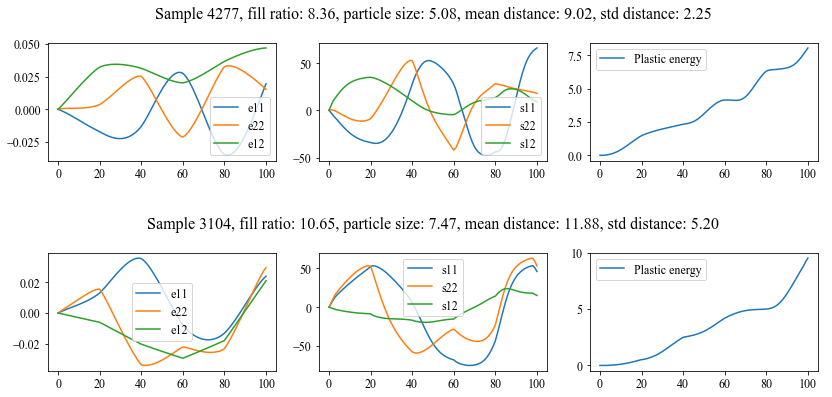

In [15]:
sample_num = 2

matplotlib.rcParams.update({'font.size': 12})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('C0', 'C1', 'C2')) 
markevery = 30

samples = random.sample(range(features.shape[0]), sample_num)
#samples = [0,1,2]

fig, big_axes = plt.subplots( figsize=(12.0, sample_num* 3.0) , nrows=sample_num, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=0):
    big_ax.set_title("Sample %d, fill ratio: %.2f, particle size: %.2f, mean distance: %.2f, std distance: %.2f\n"
                     % (samples[row],
                        features[samples[row]][0],
                        features[samples[row]][1],
                        features[samples[row]][5],
                        features[samples[row]][6])
                     , fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top=False, bottom=False, left=False, right=False)
    big_ax._frameon = False


for i in range(sample_num):
    ax = fig.add_subplot(sample_num,3,i*3+ 1)
    ax.plot(strains[samples[i],:,0], label='e11')
    ax.plot(strains[samples[i],:,1], label='e22')
    ax.plot(strains[samples[i],:,2], label='e12')
    ax.legend()

    ax = fig.add_subplot(sample_num,3,i*3+ 2)
    ax.plot(stress[samples[i],:,0], label = 's11')
    ax.plot(stress[samples[i],:,1], label = 's22')
    ax.plot(stress[samples[i],:,2], label = 's12')
    ax.legend()
    
    ax = fig.add_subplot(sample_num,3,i*3+ 3)
    #ax.plot(energy[samples[i]], label = 'Total energy')
    ax.plot(plas_energy[samples[i]], label = 'Plastic energy')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [11]:
fig.savefig('input_visualization.svg', format='svg', dpi=1200)

### Preprocessing

In [16]:
sc_f = MinMaxScaler(feature_range=(0, 1))
feature_n = sc_f.fit_transform(features)

feature_norm = pd.DataFrame(data=feature_n)
feature_norm.describe()

,0,1,2,3,4,5,6
count,8271.000000,8271.000000,8271.000000,8271.000000,8271.000000,8271.000000,8271.000000
mean,0.359716,0.595033,0.455238,0.058821,0.197177,0.106535,0.117260
std,0.245091,0.267918,0.285562,0.057893,0.169740,0.091847,0.128380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.154055,0.390296,0.206165,0.025021,0.081733,0.047768,0.032038
50%,0.321999,0.628949,0.433298,0.050569,0.142553,0.085921,0.061015
75%,0.535652,0.824410,0.693011,0.079429,0.267138,0.129736,0.165237
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
sc_e = MinMaxScaler(feature_range=(0, 5))

plas_energy_n = sc_e.fit_transform(plas_energy.reshape(-1,1))
plas_energy_norm = pd.DataFrame(data=plas_energy_n)
plas_energy_n = plas_energy_n.reshape(plas_energy.shape)
plas_energy_norm.describe()

,0
count,835371.000000
mean,0.993906
std,0.794843
min,0.000000
25%,0.336215
50%,0.838364
75%,1.516201
max,5.000000


In [20]:
sc_s = StandardScaler(with_mean=False)
stress_n = sc_s.fit_transform(stress.reshape(-1,1))
stress_norm = pd.DataFrame(data=stress_n)
stress_n = stress_n.reshape(stress.shape)
stress_norm.describe()

,0
count,2.506113e+06
mean,-3.739417e-02
std,1.000000e+00
min,-3.116856e+00
25%,-7.495537e-01
50%,-9.434717e-03
75%,7.024468e-01
max,2.377330e+00


In [21]:
sc_st = StandardScaler(with_mean=False)
strain_n = sc_st.fit_transform(strains.reshape(-1,1))
strain_norm = pd.DataFrame(data=strain_n)
strain_n = strain_n.reshape(strains.shape)
strain_norm.describe()

,0
count,2.506113e+06
mean,-8.199021e-03
std,1.000000e+00
min,-2.964703e+00
25%,-7.460747e-01
50%,-1.042318e-14
75%,7.256464e-01
max,3.053447e+00


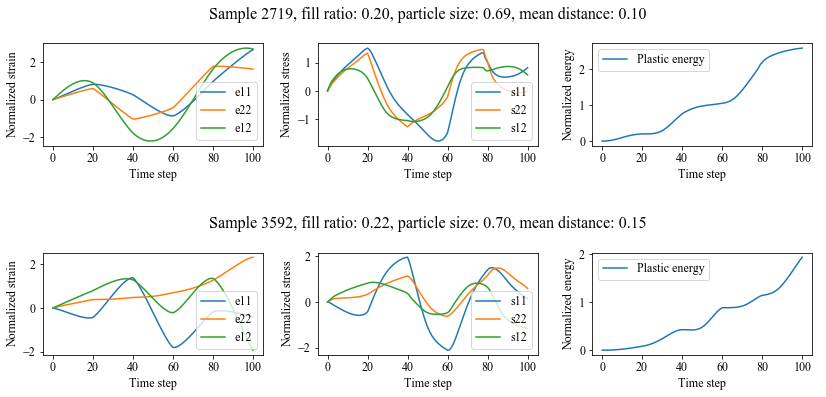

In [30]:
sample_num = 2

samples = random.sample(range(features.shape[0]), sample_num)

matplotlib.rcParams.update({'font.size': 12})

fig, big_axes = plt.subplots( figsize=(12.0, sample_num* 3.0) , nrows=sample_num, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=0):
    big_ax.set_title("Sample %d, fill ratio: %.2f, particle size: %.2f, mean distance: %.2f\n"
                     % (samples[row],
                        feature_n[samples[row]][0],
                        feature_n[samples[row]][1],
                        feature_n[samples[row]][5]),
                        fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top=False, bottom=False, left=False, right=False)
    big_ax._frameon = False


for i in range(sample_num):
    ax = fig.add_subplot(sample_num,3,i*3+ 1)
    ax.plot(strain_n[samples[i],:,0], label='e11')
    ax.plot(strain_n[samples[i],:,1], label='e22')
    ax.plot(strain_n[samples[i],:,2], label='e12')
    ax.set(xlabel='Time step', ylabel='Normalized strain')
    ax.legend()

    ax = fig.add_subplot(sample_num,3,i*3+ 2)
    ax.plot(stress_n[samples[i],:,0], label = 's11')
    ax.plot(stress_n[samples[i],:,1], label = 's22')
    ax.plot(stress_n[samples[i],:,2], label = 's12')
    ax.set(xlabel='Time step', ylabel='Normalized stress')
    ax.legend()
    
    ax = fig.add_subplot(sample_num,3,i*3+ 3)
    ax.plot(plas_energy_n[samples[i]], label = 'Plastic energy')
    ax.set(xlabel='Time step', ylabel='Normalized energy')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [195]:
fig.savefig('input_visualization.svg', format='svg', dpi=1200)

In [31]:
# feature_n_s = np.concatenate((feature_n[:,:2],feature_n[:,5:]),axis=1)
feature_n_s = feature_n
feature_n_s.shape

(8271, 7)

In [32]:
x_f = feature_n_s
x_t = strain_n
y = np.concatenate((np.expand_dims(plas_energy_n, axis=2), stress_n), axis=2)     

print(x_f.shape)
print(x_t.shape)
print(y.shape)

(8271, 7)
(8271, 101, 3)
(8271, 101, 4)


In [33]:
x_t_train, x_t_test, x_f_train, x_f_test, y_train, y_test = train_test_split(x_t, x_f, y, test_size=0.2, random_state=1)
print(x_t_train.shape)
print(x_t_test.shape)
print(x_f_train.shape)
print(x_f_test.shape)
print(y_train.shape)
print(y_test.shape)

(6616, 101, 3)
(1655, 101, 3)
(6616, 7)
(1655, 7)
(6616, 101, 4)
(1655, 101, 4)


### Build the model

In [34]:
import warnings
from keras import backend as K
from keras.engine.base_layer import Layer
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine.base_layer import InputSpec
from keras.utils.generic_utils import has_arg
from keras.utils.generic_utils import to_list
from keras.legacy.layers import Recurrent
from keras.legacy import interfaces
from keras.layers import concatenate

class CustomRNNCell(Layer):
    def __init__(self, 
                 units,
                 non_temporal_size,
                 activation='linear',
                 recurrent_activation='hard_sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 reset_after=False,
                 **kwargs):
        super(CustomRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.reset_after = reset_after
        self.state_size = (self.units, non_temporal_size)
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape_t, input_shape_f):
        input_dim_t = input_shape_t[-1]
        input_dim_f = input_shape_f[-1]

        self.kernel = self.add_weight(shape=(input_dim_t + input_dim_f, self.units * 3),
                                      name='kernel',
                                      initializer=self.kernel_initializer)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 3),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer)

        self.bias = self.add_weight(shape=(3 * self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer)
        
        self.input_bias, self.recurrent_bias = self.bias, None

        # update gate
        self.kernel_z = self.kernel[:, :self.units]
        self.recurrent_kernel_z = self.recurrent_kernel[:, :self.units]
        # reset gate
        self.kernel_r = self.kernel[:, self.units: self.units * 2]
        self.recurrent_kernel_r = self.recurrent_kernel[:,self.units:self.units * 2]
        # new gate
        self.kernel_h = self.kernel[:, self.units * 2:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units * 2:]

        self.input_bias_z = self.input_bias[:self.units]
        self.input_bias_r = self.input_bias[self.units: self.units * 2]
        self.input_bias_h = self.input_bias[self.units * 2:]
        
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]
        h_f = states[1]

        inputs_z = concatenate([inputs, h_f], axis = 1)
        inputs_r = concatenate([inputs, h_f], axis = 1)
        inputs_h = concatenate([inputs, h_f], axis = 1)

        x_z = K.dot(inputs_z, self.kernel_z)
        x_r = K.dot(inputs_r, self.kernel_r)
        x_h = K.dot(inputs_h, self.kernel_h)

        x_z = K.bias_add(x_z, self.input_bias_z)
        x_r = K.bias_add(x_r, self.input_bias_r)
        x_h = K.bias_add(x_h, self.input_bias_h)

        h_tm1_z = h_tm1
        h_tm1_r = h_tm1
        h_tm1_h = h_tm1

        recurrent_z = K.dot(h_tm1_z, self.recurrent_kernel_z)
        recurrent_r = K.dot(h_tm1_r, self.recurrent_kernel_r)

        z = self.recurrent_activation(x_z + recurrent_z)
        r = self.recurrent_activation(x_r + recurrent_r)

        recurrent_h = K.dot(r * h_tm1_h, self.recurrent_kernel_h)
        hh = self.activation(x_h + recurrent_h)
        h = z * h_tm1 + (1 - z) * hh

        return h, [h, h_f]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(CustomRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [38]:
class CustomRNN(Layer):
    def __init__(self, cell,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
#         if not hasattr(cell￼, 'call'):
#             raise ValueError('`cell` should have a `call` method. '
#                              'The RNN was passed:', cell)
#         if not hasattr(cell, 'state_size'):
#             raise ValueError('The RNN cell should have '
#                              'an attribute `state_size` '
#                              '(tuple of integers, '
#                              'one integer per RNN state).')
        super(CustomRNN, self).__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3), InputSpec(ndim=2)]
        self.state_spec = None
        self._states = None
        self.constants_spec = None
        self._num_constants = None

    @property
    def states(self):
        if self._states is None:
            if isinstance(self.cell.state_size, int):
                num_states = 1
            else:
                num_states = len(self.cell.state_size)
            return [None for _ in range(num_states)]
        return self._states

    @states.setter
    def states(self, states):
        self._states = states

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        if hasattr(self.cell.state_size, '__len__'):
            state_size = self.cell.state_size
        else:
            state_size = [self.cell.state_size]

        if getattr(self.cell, 'output_size', None) is not None:
            output_dim = self.cell.output_size
        else:
            output_dim = state_size[0]

        if self.return_sequences:
            output_shape = (input_shape[0], input_shape[1], output_dim)
        else:
            output_shape = (input_shape[0], output_dim)

        if self.return_state:
            state_shape = [(input_shape[0], dim) for dim in state_size]
            return [output_shape] + state_shape
        else:
            return output_shape

    def compute_mask(self, inputs, mask):
        if isinstance(mask, list):
            mask = mask[0]
        output_mask = mask if self.return_sequences else None
        if self.return_state:
            state_mask = [None for _ in self.states]
            return [output_mask] + state_mask
        else:
            return output_mask

    def build(self, input_shape):
        # Note input_shape will be list of shapes of initial states and
        # constants if these are passed in __call__.
        if self._num_constants is not None:
            constants_shape = input_shape[-self._num_constants:]
        else:
            constants_shape = None

        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        input_dim = input_shape[-1]
        self.input_spec[0] = InputSpec(shape=(batch_size, None, input_dim))

        # allow cell (if layer) to build before we set or validate state_spec
        if isinstance(self.cell, Layer):
            step_input_shape = (input_shape[0],) + input_shape[2:]
            if constants_shape is not None:
                self.cell.build([step_input_shape] + constants_shape)
            else:
                self.cell.build(step_input_shape)

        # set or validate state_spec
        if hasattr(self.cell.state_size, '__len__'):
            state_size = list(self.cell.state_size)
        else:
            state_size = [self.cell.state_size]

        if self.state_spec is not None:
            # initial_state was passed in call, check compatibility
            if [spec.shape[-1] for spec in self.state_spec] != state_size:
                raise ValueError(
                    'An `initial_state` was passed that is not compatible with '
                    '`cell.state_size`. Received `state_spec`={}; '
                    'however `cell.state_size` is '
                    '{}'.format(self.state_spec, self.cell.state_size))
        else:
            self.state_spec = [InputSpec(shape=(None, dim))
                               for dim in state_size]
        if self.stateful:
            self.reset_states()
        self.built = True

    def get_initial_state(self, inputs):
        # build an all-zero tensor of shape (samples, output_dim)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
#        if hasattr(self.cell.state_size, '__len__'):
#            return [K.tile(initial_state, [1, dim])
#                    for dim in self.cell.state_size]
#        else:
        return [K.tile(initial_state, [1, self.cell.state_size[0]])]

    def __call__(self, inputs, initial_state=None, constants=None, **kwargs):
        inputs, initial_state, constants = _standardize_args(
            inputs, initial_state, constants, self._num_constants)

        if initial_state is None and constants is None:
            return super(CustomRNN, self).__call__(inputs, **kwargs)

        # If any of `initial_state` or `constants` are specified and are Keras
        # tensors, then add them to the inputs and temporarily modify the
        # input_spec to include them.

        additional_inputs = []
        additional_specs = []

        if initial_state is not None:
            kwargs['initial_state'] = initial_state
            additional_inputs += initial_state
            self.state_spec = [InputSpec(shape=K.int_shape(state))
                               for state in initial_state]
            additional_specs += self.state_spec
        if constants is not None:
            kwargs['constants'] = constants
            additional_inputs += constants
            self.constants_spec = [InputSpec(shape=K.int_shape(constant))
                                   for constant in constants]
            self._num_constants = len(constants)
            additional_specs += self.constants_spec
        # at this point additional_inputs cannot be empty
        is_keras_tensor = K.is_keras_tensor(additional_inputs[0])
        for tensor in additional_inputs:
            if K.is_keras_tensor(tensor) != is_keras_tensor:
                raise ValueError('The initial state or constants of an RNN'
                                 ' layer cannot be specified with a mix of'
                                 ' Keras tensors and non-Keras tensors'
                                 ' (a "Keras tensor" is a tensor that was'
                                 ' returned by a Keras layer, or by `Input`)')

        if is_keras_tensor:
            # Compute the full input spec, including state and constants
            full_input = [inputs] + additional_inputs
            full_input_spec = self.input_spec + additional_specs
            # Perform the call with temporarily replaced input_spec
            original_input_spec = self.input_spec
            self.input_spec = full_input_spec
            if 'initial_state' in kwargs:
                kwargs.pop('initial_state')
            if 'constants' in kwargs:
                kwargs.pop('constants')
            output = super(CustomRNN, self).__call__(full_input, **kwargs)
            self.input_spec = original_input_spec
            return output
        else:
            return super(CustomRNN, self).__call__(inputs, **kwargs)

    def call(self,
             inputs,
             mask=None,
             training=None,
             initial_state=None,
             constants=None):
        if not isinstance(initial_state, (list, tuple, type(None))):
            initial_state = [initial_state]
        if not isinstance(constants, (list, tuple, type(None))):
            constants = [constants]
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            if len(inputs) == 1:
                inputs = inputs[0]
            else:
                # get initial_state from full input spec
                # as they could be copied to multiple GPU.
                if self._num_constants is None:
                    if initial_state is not None:
                        raise ValueError('Layer was passed initial state ' +
                                         'via both kwarg and inputs list)')
                    initial_state = inputs[1:]
                else:
                    if initial_state is not None and inputs[1:-self._num_constants]:
                        raise ValueError('Layer was passed initial state ' +
                                         'via both kwarg and inputs list')
                    initial_state = inputs[1:-self._num_constants]
                    if constants is None:
                        constants = inputs[-self._num_constants:]
                    elif len(inputs) > 1 + len(initial_state):
                        raise ValueError('Layer was passed constants ' +
                                         'via both kwarg and inputs list)')
                if len(initial_state) == 0:
                    initial_state = None
                inputs = inputs[0]

        prim_initial_state = self.get_initial_state(inputs)
        initial_state = prim_initial_state + initial_state

        if isinstance(mask, list):
            mask = mask[0]

        if len(initial_state) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_state)) +
                             ' initial states.')

        input_shape = K.int_shape(inputs)
        timesteps = input_shape[1]
        if self.unroll and timesteps is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')

        kwargs = {}
        if has_arg(self.cell.call, 'training'):
            kwargs['training'] = training

        if constants:
            if not has_arg(self.cell.call, 'constants'):
                raise ValueError('RNN cell does not support constants')

            def step(inputs, states):
                constants = states[-self._num_constants:]
                states = states[:-self._num_constants]
                return self.cell.call(inputs, states, constants=constants,
                                      **kwargs)
        else:
            def step(inputs, states):
                return self.cell.call(inputs, states, **kwargs)

        last_output, outputs, states = K.rnn(step,
                                             inputs,
                                             initial_state,
                                             constants=constants,
                                             go_backwards=self.go_backwards,
                                             mask=mask,
                                             unroll=self.unroll,
                                             input_length=timesteps)
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        if self.return_sequences:
            output = outputs
        else:
            output = last_output

        # Properly set learning phase
        if getattr(last_output, '_uses_learning_phase', False):
            output._uses_learning_phase = True
            for state in states:
                state._uses_learning_phase = True

        if self.return_state:
            states = to_list(states, allow_tuple=True)
            return [output] + states
        else:
            return output

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        batch_size = self.input_spec[0].shape[0]
        if not batch_size:
            raise ValueError('If a RNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the batch size by passing a '
                             '`batch_shape` argument to your Input layer.')
        # initialize state if None
        if self.states[0] is None:
            if hasattr(self.cell.state_size, '__len__'):
                self.states = [K.zeros((batch_size, dim))
                               for dim in self.cell.state_size]
            else:
                self.states = [K.zeros((batch_size, self.cell.state_size))]
        elif states is None:
            if hasattr(self.cell.state_size, '__len__'):
                for state, dim in zip(self.states, self.cell.state_size):
                    K.set_value(state, np.zeros((batch_size, dim)))
            else:
                K.set_value(self.states[0],
                            np.zeros((batch_size, self.cell.state_size)))
        else:
            states = to_list(states, allow_tuple=True)
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 ' state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if hasattr(self.cell.state_size, '__len__'):
                    dim = self.cell.state_size[index]
                else:
                    dim = self.cell.state_size
                if value.shape != (batch_size, dim):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, dim)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def get_config(self):
        config = {'return_sequences': self.return_sequences,
                  'return_state': self.return_state,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll}
        if self._num_constants is not None:
            config['num_constants'] = self._num_constants

        cell_config = self.cell.get_config()
        config['cell'] = {'class_name': self.cell.__class__.__name__,
                          'config': cell_config}
        base_config = super(CustomRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config, custom_objects=None):
        from . import deserialize as deserialize_layer
        cell = deserialize_layer(config.pop('cell'),
                                 custom_objects=custom_objects)
        num_constants = config.pop('num_constants', None)
        layer = cls(cell, **config)
        layer._num_constants = num_constants
        return layer

    @property
    def trainable_weights(self):
        if not self.trainable:
            return []
        if isinstance(self.cell, Layer):
            return self.cell.trainable_weights
        return []

    @property
    def non_trainable_weights(self):
        if isinstance(self.cell, Layer):
            if not self.trainable:
                return self.cell.weights
            return self.cell.non_trainable_weights
        return []

    @property
    def losses(self):
        layer_losses = super(CustomRNN, self).losses
        if isinstance(self.cell, Layer):
            return self.cell.losses + layer_losses
        return layer_losses

    def get_losses_for(self, inputs=None):
        if isinstance(self.cell, Layer):
            cell_losses = self.cell.get_losses_for(inputs)
            return cell_losses + super(CustomRNN, self).get_losses_for(inputs)
        return super(CustomRNN, self).get_losses_for(inputs)
    
def _standardize_args(inputs, initial_state, constants, num_constants):
    initial_state = None
    constants = None
    return inputs, initial_state, constants

In [39]:
class CustomGRU(CustomRNN):
    @interfaces.legacy_recurrent_support
    def __init__(self, 
                 units,
                 non_temporal_size = 3,
                 activation='tanh',
                 recurrent_activation='hard_sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 reset_after=False,
                 **kwargs):

        cell = CustomRNNCell(units = units,
                       non_temporal_size = non_temporal_size,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation,
                       reset_after=reset_after)
        super(CustomGRU, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(CustomGRU, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=None)
        
    def build(self, input_shape):

        batch_size = None
        input_t_dim = input_shape[0][-1]
        self.input_spec[0] = InputSpec(shape=(batch_size, None, input_t_dim))
        
        input_f_dim = input_shape[1][-1]
        self.input_spec[1] = InputSpec(shape=(batch_size, input_f_dim))

        # allow cell (if layer) to build before we set or validate state_spec
        if isinstance(self.cell, Layer):
            step_input_t_shape = (input_shape[0][0],) + input_shape[0][2:]
            step_input_f_shape = input_shape[1]
            self.cell.build(step_input_t_shape, step_input_f_shape)

        # set or validate state_spec
        if hasattr(self.cell.state_size, '__len__'):
            state_size = list(self.cell.state_size)
        else:
            state_size = [self.cell.state_size]

        if self.state_spec is not None:
            # initial_state was passed in call, check compatibility
            if [spec.shape[-1] for spec in self.state_spec] != state_size:
                raise ValueError(
                    'An `initial_state` was passed that is not compatible with '
                    '`cell.state_size`. Received `state_spec`={}; '
                    'however `cell.state_size` is '
                    '{}'.format(self.state_spec, self.cell.state_size))
        else:
            self.state_spec = [InputSpec(shape=(None, dim))
                               for dim in state_size]
        if self.stateful:
            self.reset_states()
        self.built = True

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    @property
    def reset_after(self):
        return self.cell.reset_after

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(CustomGRU, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

### Train the model

In [25]:
model_name = '3_500'
units = 500
time_span = 101
epochs = 1000
input_dim_t = x_t_train.shape[2]
input_dim_f = x_f_train.shape[1]
output_dim = y_train.shape[2]

In [26]:
# LR = LeakyReLU()
# LR.__name__ = 'relu'

K.clear_session()

input_t = Input(shape=(time_span, input_dim_t))
input_f = Input(shape=(input_dim_f,))

x = CustomGRU(units = units, non_temporal_size = input_dim_f, 
              return_sequences=True, activation = 'linear')([input_t, input_f])
x = LeakyReLU()(x)
x = GRU(units, return_sequences=True, activation = 'linear')(x)
x = LeakyReLU()(x)
x = GRU(units, return_sequences=True, activation = 'linear')(x)
x = LeakyReLU()(x)
out = TimeDistributed(Dense(output_dim))(x)

model = Model(inputs=[input_t, input_f], outputs=out)
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 3)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
custom_gru_1 (CustomGRU)        (None, 101, 500)     762000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 101, 500)     0           custom_gru_1[0][0]               
__________

In [89]:
#model.load_weights('3_500_1_cube_weights.h5')

### Training and Results

In [41]:
# history = model.fit([x_t_train, x_f_train], y_train, 
#                     validation_data=([x_t_test,x_f_test], y_test), 
#                     epochs=epochs, 
#                     batch_size=64, 
#                     verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6616 samples, validate on 1655 samples
Epoch 1/400
6616/6616 [==============================] - 48s 7ms/step - loss: 0.3082 - mean_squared_error: 0.2081 - val_loss: 0.1301 - val_mean_squared_error: 0.0328
Epoch 2/400
6616/6616 [==============================] - 45s 7ms/step - loss: 0.0935 - mean_squared_error: 0.0184 - val_loss: 0.0725 - val_mean_squared_error: 0.0107
Epoch 3/400
6616/6616 [==============================] - 45s 7ms/step - loss: 0.0675 - mean_squared_error: 0.0097 - val_loss: 0.0646 - val_mean_squared_error: 0.0085
Epoch 4/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0517 - mean_squared_error: 0.0061 - val_loss: 0.0492 - val_mean_squared_error: 0.0052
Epoch 5/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0471 - mean_squared_error: 0.0053 - val_loss: 0.0553 - val_mean_squared_error: 0.0073
Epoch 6/400
6616/6616 [==============================] - 44s 7ms/step - lo

6616/6616 [==============================] - 44s 7ms/step - loss: 0.0161 - mean_squared_error: 6.5836e-04 - val_loss: 0.0210 - val_mean_squared_error: 0.0012
Epoch 96/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0150 - mean_squared_error: 6.3708e-04 - val_loss: 0.0193 - val_mean_squared_error: 0.0011
Epoch 97/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0160 - mean_squared_error: 6.8656e-04 - val_loss: 0.0166 - val_mean_squared_error: 8.3227e-04
Epoch 98/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0160 - mean_squared_error: 6.6458e-04 - val_loss: 0.0173 - val_mean_squared_error: 9.5354e-04
Epoch 99/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0158 - mean_squared_error: 6.7451e-04 - val_loss: 0.0187 - val_mean_squared_error: 9.5697e-04
Epoch 100/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0170 - mean_squared_error: 7.2773e-04 - val_loss: 0.0199 - val_m

Epoch 142/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0147 - mean_squared_error: 5.3132e-04 - val_loss: 0.0166 - val_mean_squared_error: 8.8205e-04
Epoch 143/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0118 - mean_squared_error: 3.6782e-04 - val_loss: 0.0139 - val_mean_squared_error: 7.0700e-04
Epoch 144/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0122 - mean_squared_error: 3.7900e-04 - val_loss: 0.0136 - val_mean_squared_error: 7.1082e-04
Epoch 145/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0115 - mean_squared_error: 3.4580e-04 - val_loss: 0.0148 - val_mean_squared_error: 7.2768e-04
Epoch 146/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0132 - mean_squared_error: 4.4531e-04 - val_loss: 0.0160 - val_mean_squared_error: 8.3655e-04
Epoch 147/400
6616/6616 [==============================] - 44s 7ms/step - loss: 0.0141 - mean_squared_error: 4.8703e-04 

6616/6616 [==============================] - 46s 7ms/step - loss: 0.0102 - mean_squared_error: 2.5218e-04 - val_loss: 0.0140 - val_mean_squared_error: 7.1788e-04
Epoch 235/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0105 - mean_squared_error: 2.6570e-04 - val_loss: 0.0133 - val_mean_squared_error: 6.8265e-04
Epoch 236/400
6616/6616 [==============================] - 47s 7ms/step - loss: 0.0099 - mean_squared_error: 2.3892e-04 - val_loss: 0.0112 - val_mean_squared_error: 5.9982e-04
Epoch 237/400
6616/6616 [==============================] - 47s 7ms/step - loss: 0.0093 - mean_squared_error: 2.1755e-04 - val_loss: 0.0126 - val_mean_squared_error: 6.9506e-04
Epoch 238/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0106 - mean_squared_error: 2.6750e-04 - val_loss: 0.0136 - val_mean_squared_error: 7.1135e-04
Epoch 239/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0104 - mean_squared_error: 2.5443e-04 - val_loss: 0.

6616/6616 [==============================] - 46s 7ms/step - loss: 0.0085 - mean_squared_error: 1.7468e-04 - val_loss: 0.0115 - val_mean_squared_error: 6.0072e-04
Epoch 327/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0078 - mean_squared_error: 1.4733e-04 - val_loss: 0.0116 - val_mean_squared_error: 6.2692e-04
Epoch 328/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0083 - mean_squared_error: 1.6459e-04 - val_loss: 0.0124 - val_mean_squared_error: 6.7030e-04
Epoch 329/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0085 - mean_squared_error: 1.7349e-04 - val_loss: 0.0111 - val_mean_squared_error: 5.7015e-04
Epoch 330/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0079 - mean_squared_error: 1.4947e-04 - val_loss: 0.0115 - val_mean_squared_error: 6.3991e-04
Epoch 331/400
6616/6616 [==============================] - 46s 7ms/step - loss: 0.0078 - mean_squared_error: 1.4855e-04 - val_loss: 0.

In [44]:
print('SMAE for train-set')
print(history.history['loss'][-1]/5.48)
print('SMAE for test-set')
print(history.history['val_loss'][-1]/5.48)

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
ypred_plastic = ypred[:,:,0]
for sample in range(y_train.shape[0]):
    mean_max_inc[sample] = mon_increase_error(ypred_plastic[sample,:])
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean()/5.48)

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
ypred_plastic = ypred[:,:,0]
for sample in range(y_test.shape[0]):
    mean_max_inc[sample] = mon_increase_error(ypred_plastic[sample,:])
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean()/5.48)

SMAE for train-set
0.0013229253832589005
SMAE for test-set
0.0019426941042125815
Scaled mean max plastic energy decrease for train-set
0.0017975023880642258
Scaled mean max plastic energy decrease for test-set
0.0018466217080856768


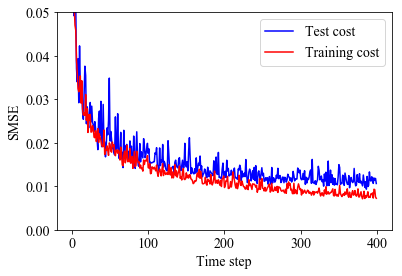

In [46]:
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

In [225]:
fig.savefig('convergance'+model_name+'.svg', format='svg', dpi=1200)
fig.savefig('convergance'+model_name+'.eps', format='eps', dpi=1200)

In [47]:
model.save('Models/'+model_name+'.h5')
model.save_weights('Models/'+model_name+'_weights.h5')

### Test-set Evaluation

3_500
Sample number 1555, fill ratio: 15.84, particle size: 5.07, mean distance: 9.50, std distance: 0.67



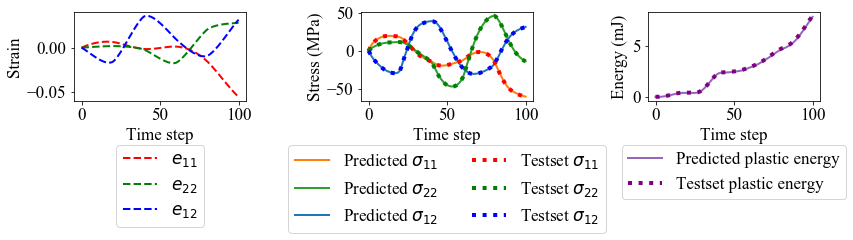

In [260]:
# model_name = '3_500_1'
print(model_name)
# model_loaded = load_model('Models/'+model_name+'.h5')
test_sample=np.random.randint(y_test.shape[0])
test_sample = 1555

ypred = model.predict(x_test[test_sample,:,:].reshape(1,101,input_dim))

y_pred_s = sc_s.inverse_transform(ypred[:,:,1:].reshape(-1,1))
y_pred_s = y_pred_s.reshape((101,3))
y_pred_e = sc_e.inverse_transform(ypred[:,:,0].reshape(-1,1))
y_pred_e = y_pred_e.reshape((101,1))

ytest_s = sc_s.inverse_transform(y_test[test_sample,:,1:].reshape(-1,1))
ytest_s = ytest_s.reshape((101,3))
ytest_e = sc_e.inverse_transform(y_test[test_sample,:,0].reshape(-1,1))
ytest_e = ytest_e.reshape((101,1))

x_test_sr = sc_st.inverse_transform(x_test[test_sample,:,7:].reshape(-1,1))
x_test_sr = x_test_sr.reshape((101,3))

x_test_f = sc_f.inverse_transform(x_test[test_sample,0,:7].reshape(-1,7))
x_test_f = x_test_f.reshape((7))

print("Sample number %d, fill ratio: %.2f, particle size: %.2f, mean distance: %.2f, std distance: %.2f\n"
                     % (test_sample,
                        x_test_f[0],
                        x_test_f[1],
                        x_test_f[5],
                        x_test_f[6]))

matplotlib.rcParams.update({'font.size': 17})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12.0, 4.5))
ax1.plot(x_test_sr[:,0],'r',linestyle = '--', linewidth=2,label="$e_{11}$")
ax1.plot(x_test_sr[:,1],'g',linestyle = '--', linewidth=2,label="$e_{22}$")
ax1.plot(x_test_sr[:,2],'b',linestyle = '--', linewidth=2,label="$e_{12}$")

ax1.set(xlabel='Time step', ylabel='Strain')
lgd1 = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

ax2.plot(y_pred_s[:,0],'C1',linewidth=2,label="Predicted $\sigma_{11}$")
ax2.plot(y_pred_s[:,1],'C2',linewidth=2,label="Predicted $\sigma_{22}$")
ax2.plot(y_pred_s[:,2],'C0',linewidth=2,label="Predicted $\sigma_{12}$")

ax2.plot(ytest_s[:,0],'r', linestyle = ':',linewidth=4,label="Testset $\sigma_{11}$")
ax2.plot(ytest_s[:,1],'g', linestyle = ':',linewidth=4,label="Testset $\sigma_{22}$")
ax2.plot(ytest_s[:,2],'b' , linestyle = ':' ,linewidth=4,label="Testset $\sigma_{12}$")

ax2.set(xlabel='Time step', ylabel='Stress (MPa)')
lgd2 = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

ax3.plot(y_pred_e[:,0],'C4',linewidth=2, label="Predicted plastic energy")
ax3.plot(ytest_e[:,0],'purple', linestyle = ':',linewidth=4,label="Testset plastic energy")

ax3.set(xlabel='Time step', ylabel='Energy (mJ)')
lgd3 = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

fig.tight_layout()

In [261]:
fig_name = 'trained_result_final'
fig.savefig(fig_name+'.png', format='png', dpi=1200, bbox_extra_artists=(lgd1, lgd2, lgd3), bbox_inches='tight')
fig.savefig(fig_name+'.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd1, lgd2, lgd3), bbox_inches='tight')

### Test uni-directional tension

In [67]:
with open('Data/'+'RVEs_postprocessing_variables_uni.p', 'rb') as file:
    test_uni_data = pickle.load(file , encoding='latin1')
    
test_uni_strain = loadmat('Data/unidirection.mat')

test_uni_f = np.array ([6.2155,  7.4891,  5.3629  , 5.4472, 55.5971, 20.9257,  16.2031])

test_uni_valid_rves = get_valid_RVEs(test_uni_data)
    
test_uni_plas_energy = []
for rve in test_uni_valid_rves:
    plas = test_uni_data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']
    plas = np.append(plas,np.zeros(101-len(plas)))
    test_uni_plas_energy.append(plas)
test_uni_plas_energy = np.array(test_uni_plas_energy)

test_uni_stress = []
for rve in test_uni_valid_rves:
    ss = test_uni_data['RVE'+rve]['Sample1']['BC'+rve]['P']
    ss = np.append(ss,np.zeros((101-ss.shape[0],2,2)), axis= 0)
    s11 = ss[:,0,0]
    s12 = ss[:,0,1]
    s22 = ss[:,1,1]
    test_uni_stress.append([s11, s22, s12])
test_uni_stress = np.array(test_uni_stress)
test_uni_stress = test_uni_stress.transpose(0,2,1)

test_uni_f = np.expand_dims(test_uni_f, axis=0)
test_uni_f = sc_f.transform(test_uni_f)

# test_uni_f = np.concatenate((test_uni_f[:,:2],test_uni_f[:,5:]),axis=1)
test_uni_f = np.repeat(test_uni_f, 101, axis=0)
test_uni_f = np.expand_dims(test_uni_f, 0)

st = test_uni_strain['INFO']['Realization']['Fine_strain_history'].transpose(2,0,1)
strains = []
for rve in test_uni_valid_rves:
    strains.append(st[int(rve)-1,:,:])
strains = np.asarray(strains)

strain_n = sc_st.transform(strains.reshape(-1,1))
strain_n = strain_n.reshape(strains.shape)

In [68]:
test_uni_x = np.concatenate((test_uni_f, strain_n), axis=2)
test_uni_y = np.concatenate((np.expand_dims(test_uni_plas_energy, axis=2), test_uni_stress), axis=2)

print(test_uni_x.shape)
print(test_uni_y.shape)

(1, 101, 10)
(1, 101, 4)


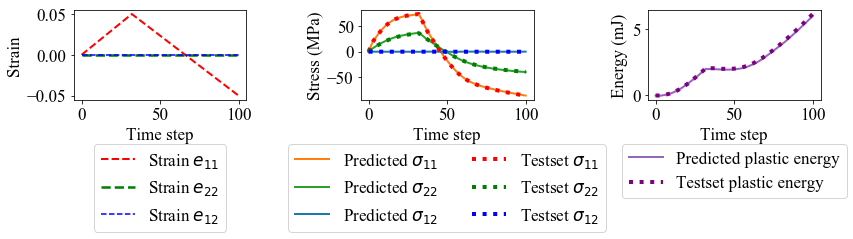

In [262]:
# model_name = '3_500_1'
# model_loaded = load_model('Models/'+model_name+'.h5')
ypred = model.predict(test_uni_x)
#ypred = ypred.reshape((101, output_dim))

y_pred_s = sc_s.inverse_transform(ypred[:,:,1:].reshape(-1,1))
y_pred_s = y_pred_s.reshape((101,3))
y_pred_e = sc_e.inverse_transform(ypred[:,:,0].reshape(-1,1))
y_pred_e = y_pred_e.reshape((101,1))

ytest = test_uni_y[0,:]

test_uni_x_st = test_uni_x[:,:, 7:]
test_uni_x_st = sc_st.inverse_transform(test_uni_x_st.reshape(-1,1))
test_uni_x_st = test_uni_x_st.reshape((101,3))

matplotlib.rcParams.update({'font.size': 17})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12.0, 4.5))

ax1.plot(test_uni_x_st[:,0],'r',linestyle = '--',linewidth=2,label="Strain $e_{11}$")
ax1.plot(test_uni_x_st[:,1],'g',linestyle = '--',linewidth=2.5,label="Strain $e_{22}$")
ax1.plot(test_uni_x_st[:,2],'b',linestyle = '--',linewidth=1.5,label="Strain $e_{12}$")

ax1.set(xlabel='Time step', ylabel='Strain')
lgd1 = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

ax2.plot(y_pred_s[:,0],'C1',linewidth=2,label="Predicted $\sigma_{11}$")
ax2.plot(y_pred_s[:,1],'C2',linewidth=2,label="Predicted $\sigma_{22}$")
ax2.plot(y_pred_s[:,2],'C0',linewidth=2,label="Predicted $\sigma_{12}$")

ax2.plot(ytest[:,1],'r', linestyle = ':',linewidth=4,label="Testset $\sigma_{11}$")
ax2.plot(ytest[:,2],'g', linestyle = ':',linewidth=4,label="Testset $\sigma_{22}$")
ax2.plot(ytest[:,3],'b' , linestyle = ':' ,linewidth=4,label="Testset $\sigma_{12}$")

ax2.set(xlabel='Time step', ylabel='Stress (MPa)')
lgd2 = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

ax3.plot(y_pred_e[:,0],'C4',linewidth=2, label="Predicted plastic energy")
ax3.plot(ytest[:,0],'purple', linestyle = ':',linewidth=4,label="Testset plastic energy")

ax3.set(xlabel='Time step', ylabel='Energy (mJ)')
lgd3 = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

fig.tight_layout()

In [263]:
fig_name = 'unidirectional_final'
fig.savefig(fig_name+'.png', format='png', dpi=1200, bbox_extra_artists=(lgd1, lgd2, lgd3), bbox_inches='tight')
fig.savefig(fig_name+'.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd1, lgd2, lgd3), bbox_inches='tight')

### Yield surface plot

In [47]:
def pri_s(s11,s22,s12):
    if abs(s11) < 1e-3 and abs(s22) < 1e-3 and abs(s12) < 1e-3:
        return 0.0, 0.0
    theta_p = (np.arctan(2*s12/(s11-s22)))/2
    Q = np.array([[np.cos(theta_p), np.sin(theta_p)],[-1*np.sin(theta_p), np.cos(theta_p)]])
    S = np.array([[s11, s12],[s12, s22]])
    S_p = np.dot(Q, S)
    S_p = np.dot(S_p,Q.T)
#     print('s11: %.2f, s22: %.2f, s12: %.2f, theta: %.2f, s1: %.2f, s2: %.2f\n'%(s11,s22,s12,theta_p,S_p[0,0],S_p[1,1]))
    return S_p[0,0], S_p[1,1]

In [72]:
data_list = ['../../Data_v1/RVEs_postprocessing_variables_yieldsurface.p']
DOE = loadmat('../../Data_v1/yield_surface.mat')

n_samples = 160

data = {}
for file in data_list:
    with open(file, 'rb') as file:
        data_local = pickle.load(file , encoding='latin1')
        data.update(data_local)
        
valid_rves = [str(n) for n in range(1,n_samples+1)]

energy = []
plas_energy = []
for rve in valid_rves:
    ener = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
    plas = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']
    ener = np.append(ener,np.zeros(101-len(ener)))
    plas = np.append(plas,np.zeros(101-len(plas)))
    energy.append(ener)
    plas_energy.append(plas)
energy = np.array(energy)
plas_energy = np.array(plas_energy)

stress = []
for rve in valid_rves:
    ss = data['RVE'+rve]['Sample1']['BC'+rve]['P']
    ss = np.append(ss,np.zeros((101-ss.shape[0],2,2)), axis= 0)
    s11 = ss[:,0,0]
    s12 = ss[:,0,1]
    s22 = ss[:,1,1]
    stress.append([s11, s22, s12])
stress = np.array(stress)
stress = stress.transpose(0,2,1)

st = DOE['INFO']['Realization']['Fine_strain_history'].transpose(2,0,1)
strains = []
for rve in valid_rves:
    strains.append(st[int(rve)-1,:,:])
strains = np.asarray(strains)* 0.02

strain_sc = sc_st.transform(strains.reshape(-1,1))
strain_sc = strain_sc.reshape(n_samples,101,3)
print(strain_sc.shape)

(160, 101, 3)


In [73]:
yield_f = np.array ([6.2155,  7.4891,  5.3629  , 5.4472, 55.5971, 20.9257,  16.2031])
yield_f = np.expand_dims(yield_f, axis=0)
yield_f = sc_f.transform(yield_f)
yield_f = np.concatenate((yield_f[:,:2],yield_f[:,5:]),axis=1)
yield_f = np.repeat(yield_f, 101, axis=0)
yield_f = np.expand_dims(yield_f, axis=0)
yield_f = np.repeat(yield_f, 160, axis=0)
print(yield_f.shape)

(160, 101, 4)


In [74]:
test_uni_x = np.concatenate((yield_f, strain_sc), axis=2)
test_uni_y = np.concatenate((np.expand_dims(plas_energy, axis=2), stress), axis=2)

print(test_uni_x.shape)
print(test_uni_y.shape)

(160, 101, 7)
(160, 101, 4)


In [75]:
yield_y = model.predict(test_uni_x)
print(yield_y.shape)

y_pred_s = sc_s.inverse_transform(yield_y[:,:,1:].reshape(-1,1))
y_pred_s = y_pred_s.reshape((n_samples,101,3))
y_pred_e = sc_e.inverse_transform(yield_y[:,:,0].reshape(-1,1))
y_pred_e = y_pred_e.reshape((n_samples,101,1))
print(y_pred_s.shape)
print(y_pred_e.shape)

(160, 101, 4)
(160, 101, 3)
(160, 101, 1)


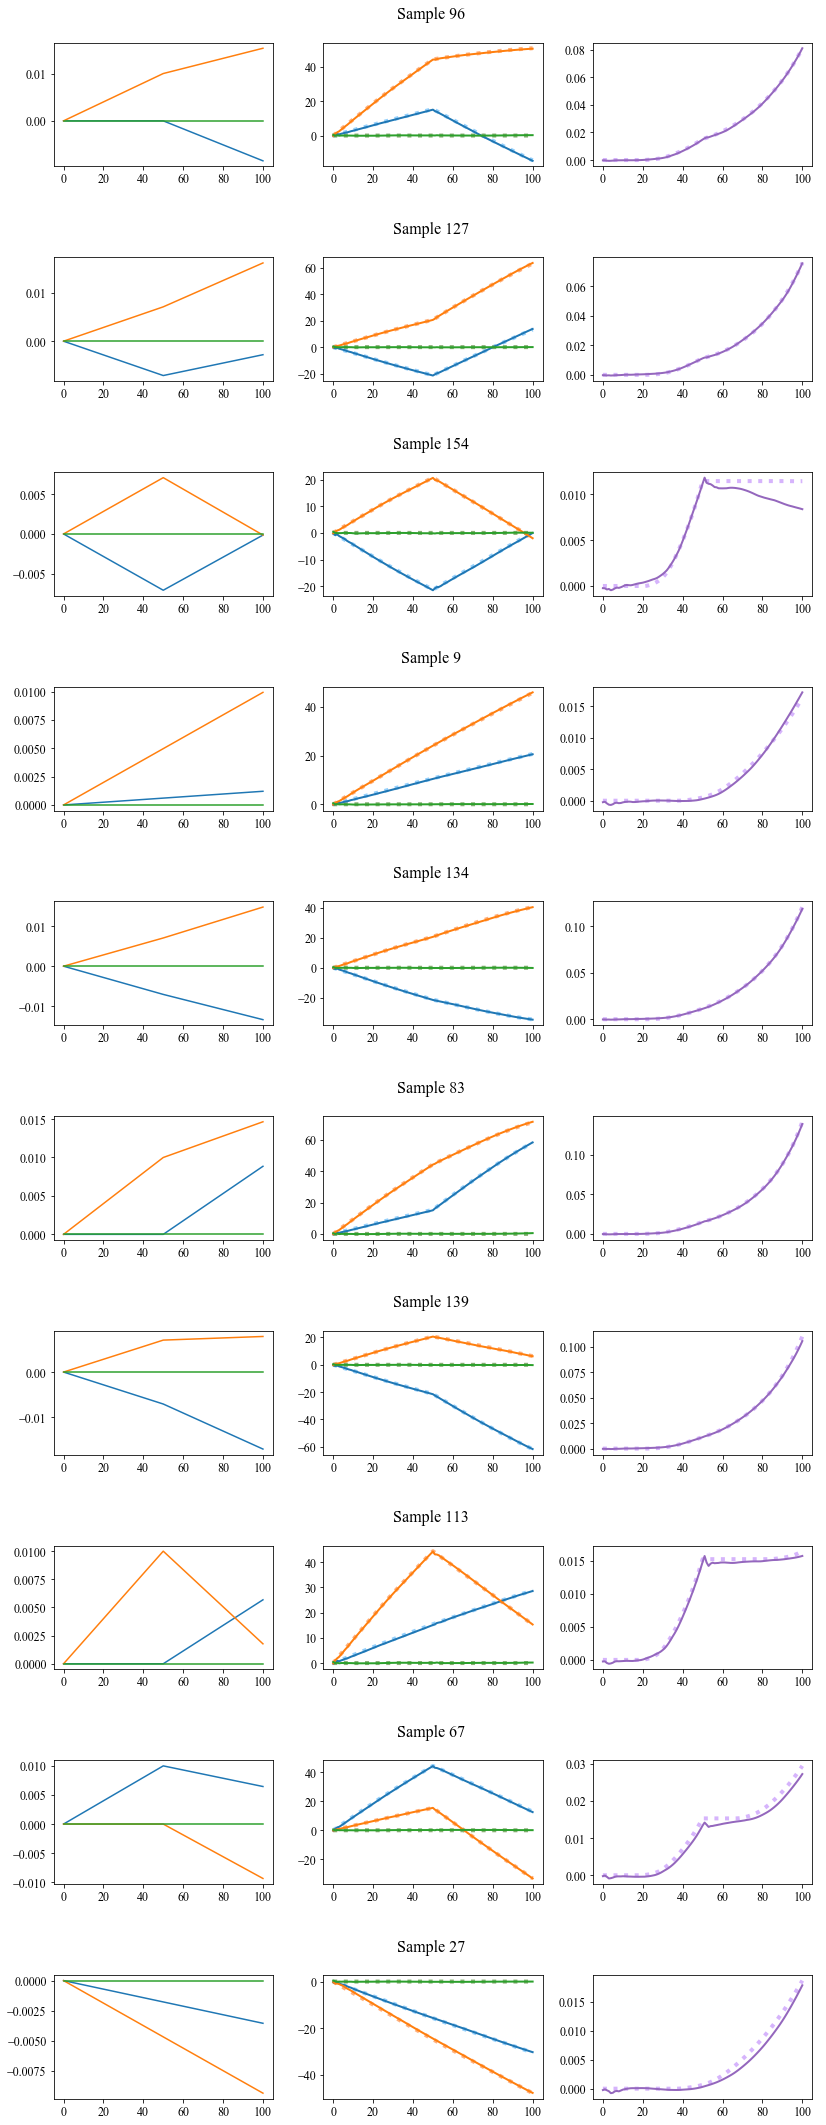

In [67]:
sample_num = 10

matplotlib.rcParams.update({'font.size': 12})

samples = random.sample(range(strains.shape[0]), sample_num)

fig, big_axes = plt.subplots( figsize=(12.0, sample_num* 3.0) , nrows=sample_num, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=0):
    big_ax.set_title("Sample %d \n"
                     % (samples[row],)
                     , fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top=False, bottom=False, left=False, right=False)
    big_ax._frameon = False


for i in range(sample_num):
    ax = fig.add_subplot(sample_num,3,i*3+ 1)
    ax.plot(strains[samples[i],:,0], label='e11')
    ax.plot(strains[samples[i],:,1], label='e22')
    ax.plot(strains[samples[i],:,2], label='e12')
#     ax.legend()

    ax = fig.add_subplot(sample_num,3,i*3+ 2)
    ax.plot(stress[samples[i],:,0],'#95d0fc', linestyle = ':',linewidth=4,label="Testset s11")
    ax.plot(stress[samples[i],:,1],'#ffb07c', linestyle = ':',linewidth=4,label="Testset s22")
    ax.plot(stress[samples[i],:,2],'#87ae73' , linestyle = ':' ,linewidth=4,label="Testset s12")
    ax.plot(y_pred_s[samples[i],:,0],'C0',linewidth=2,label="Predicted s11")
    ax.plot(y_pred_s[samples[i],:,1],'C1',linewidth=2,label="Predicted s22")
    ax.plot(y_pred_s[samples[i],:,2],'C2',linewidth=2,label="Predicted s12")
#     ax.legend()
    
    ax = fig.add_subplot(sample_num,3,i*3+ 3)
    ax.plot(plas_energy[samples[i]],'#d6b4fc', linestyle = ':',linewidth=4,label="Testset plastic energy")
    ax.plot(y_pred_e[samples[i],:,0],'C4',linewidth=2, label="Predicted plastic energy")
#     ax.legend()
    
plt.tight_layout()
plt.show()

In [ ]:
threshold = 0.01

n_samples = 40
s1_plas = np.zeros((4,n_samples,))
s2_plas = np.zeros((4,n_samples,))
s_path = np.zeros((20,51,2))

for sample in range(0,n_samples):
    for ind in range(101):
        if plas_energy[sample, ind]> threshold:
            s11_plas = stress[sample,ind,0]
            s22_plas = stress[sample,ind,1]
            s12_plas = stress[sample,ind,2]
            s1_plas[0,sample], s2_plas[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = plas_energy[start + sample, 51]
        for ind in range(51, 101):
            if plas_energy[start + sample, ind]> threshold + base_plas_energy:
                s11_plas = stress[start + sample,ind,0]
                s22_plas = stress[start + sample,ind,1]
                s12_plas = stress[start + sample,ind,2]
                s1_plas[loading+1,sample], s2_plas[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
load_id = 0
for loading in [40,80,120]:
# for loading in range(40,60):
    for ind in range(51):
        s_path[load_id,ind,:] =  pri_s(stress[loading,ind,0], stress[loading,ind,1], stress[loading,ind,2])
#         if ind>0:
#             if np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,0])>np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,1]):
#                 s_temp = s_path[load_id,ind,0]
#                 s_path[load_id,ind,0] = s_path[load_id,ind,1]
#                 s_path[load_id,ind,1] = s_temp
    load_id += 1

matplotlib.rcParams.update({'font.size': 14})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('g', 'b', 'C4')) 
fig = plt.figure(figsize=(8.0, 6.0))
ax = plt.subplot(111)
plt.grid()

plt.plot(s1_plas[0], s2_plas[0], 'r', linestyle = ':', linewidth=4, label='Original Yield surface')
plt.plot(s1_plas[1], s2_plas[1], 'g', linestyle = ':', linewidth=4, label='Yield surface 1')
plt.plot(s1_plas[2], s2_plas[2], 'b', linestyle = ':', linewidth=4, label='Yield surface 2')
plt.plot(s1_plas[3], s2_plas[3], 'C4' , linestyle = ':', linewidth=4, label='Yield surface 3')

########################################### out prediction ###########################################
s1_plas_pred = np.zeros((4,n_samples,))
s2_plas_pred = np.zeros((4,n_samples,))

for sample in range(0,n_samples):
    for ind in range(101):
        if y_pred_e[sample, ind, 0]> threshold:
            s11_plas = y_pred_s[sample,ind,0]
            s22_plas = y_pred_s[sample,ind,1]
            s12_plas = y_pred_s[sample,ind,2]
            s1_plas_pred[0,sample], s2_plas_pred[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = y_pred_e[start + sample, 51,0]
        for ind in range(51, 101):
            if y_pred_e[start + sample, ind,0]> threshold + base_plas_energy:
                s11_plas = y_pred_s[start + sample,ind,0]
                s22_plas = y_pred_s[start + sample,ind,1]
                s12_plas = y_pred_s[start + sample,ind,2]
                s1_plas_pred[loading+1,sample], s2_plas_pred[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
plt.plot(s1_plas_pred[0], s2_plas_pred[0], 'C1', linewidth=2, label='Original Yield surface prediction')
plt.plot(s1_plas_pred[1], s2_plas_pred[1], color = 'C2', linewidth=2, label='Yield surface prediction 1')
plt.plot(s1_plas_pred[2], s2_plas_pred[2], color = 'C0', linewidth=2, label='Yield surface prediction 1')
plt.plot(s1_plas_pred[3], s2_plas_pred[3], color = 'purple', linewidth=2, label='Yield surface prediction 1')

for i in range(3):
    plt.plot(s_path[i,:,0], s_path[i,:,1], '--', color = next(color), marker=next(marker), markevery=10, label='Loading {}'.format(i+1))
#     plt.plot(s_path[i,:,0], s_path[i,:,1], '--', markevery=10, label='Loading {}'.format(i+1))

ax.set(xlabel='First principal stress (MPa)', ylabel='Second principal stress (MPa)')

plt.axis('equal')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

In [ ]:
fig.savefig('yield_surface.svg', format='svg', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('yield_surface.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')

### Comparing Different Configurations

In [ ]:
model_loaded = load_model('2_200.h5')
h_train = model_loaded.evaluate(X_train,y_train)
h_test = model_loaded.evaluate(X_test,y_test)
print(h_train)
print(h_test)

In [ ]:
model_loaded = load_model('2_400_2.h5')
h_train = model_loaded.evaluate(X_train,y_train)
h_test = model_loaded.evaluate(X_test,y_test)
print(h_train)
print(h_test)

In [ ]:
model_loaded = load_model('3_200.h5')
h_train = model_loaded.evaluate(X_train,y_train)
h_test = model_loaded.evaluate(X_test,y_test)
print(h_train)
print(h_test)

### Dense mix -- (A)

In [116]:
feature_n_s = np.concatenate((feature_n[:,:2],feature_n[:,5:]),axis=1)
xt_train, xt_test, xf_train, xf_test, y_train, y_test = train_test_split(strains, feature_n_s, y, test_size=0.2)
print(xt_train.shape)
print(xt_test.shape)
print(xf_train.shape)
print(xf_test.shape)
print(y_train.shape)
print(y_test.shape)

(4024, 101, 3)
(1007, 101, 3)
(4024, 4)
(1007, 4)
(4024, 101, 4)
(1007, 101, 4)


In [117]:
model_name = '3_500_leaky_mae_500_densemix'
units = 500
time_span = 101
training_epochs = 500
f_input_dim = xf_train.shape[1]
input_dim = xt_train.shape[2]
output_dim = y_train.shape[2]

In [432]:
LR = LeakyReLU()
LR.__name__ = 'relu'
K.clear_session()

feature_input = Input(shape=(f_input_dim,))
repeated = Lambda(lambda x: K.repeat(x, 101))(feature_input)
dense_1_h = TimeDistributed(Dense(100, activation=LR))(repeated)
series_input = Input(shape=(101, input_dim))
gru1 = GRU(units, return_sequences=True, activation = LR)(series_input)
gru2 = GRU(units, return_sequences=True, activation = LR)(gru1)
gru3 = GRU(units, return_sequences=True, activation = LR)(gru2)
merged = Concatenate(axis=2)([gru3, dense_1_h])
out = Dense(output_dim)(merged)

model = Model(inputs=[feature_input,series_input], outputs=out)
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')

In [433]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 101, 3)       0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 101, 500)     756000      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 101, 500)     1501500     gru_1[0][0]                      
__________________________________________________________________________________________________
lambda_1 (

In [434]:
history = model.fit([xf_train, xt_train], y_train,validation_data=([xf_test, xt_test],y_test), epochs=training_epochs,
          batch_size=64, verbose=1)

Train on 4024 samples, validate on 1007 samples
Epoch 1/500
4024/4024 [==============================] - 33s 8ms/step - loss: 0.1655 - mean_squared_error: 0.0958 - val_loss: 0.1207 - val_mean_squared_error: 0.0719
Epoch 2/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.1017 - mean_squared_error: 0.0685 - val_loss: 0.0792 - val_mean_squared_error: 0.0532
Epoch 3/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0723 - mean_squared_error: 0.0437 - val_loss: 0.0664 - val_mean_squared_error: 0.0457
Epoch 4/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0533 - mean_squared_error: 0.0252 - val_loss: 0.0534 - val_mean_squared_error: 0.0149
Epoch 5/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0440 - mean_squared_error: 0.0153 - val_loss: 0.0398 - val_mean_squared_error: 0.0116
Epoch 6/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0390 - mean_squared_error: 0.0123 - val_lo

4024/4024 [==============================] - 30s 7ms/step - loss: 0.0102 - mean_squared_error: 7.6378e-04 - val_loss: 0.0139 - val_mean_squared_error: 8.1177e-04
Epoch 97/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0108 - mean_squared_error: 7.8573e-04 - val_loss: 0.0105 - val_mean_squared_error: 7.0321e-04
Epoch 98/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0097 - mean_squared_error: 7.2782e-04 - val_loss: 0.0111 - val_mean_squared_error: 7.8400e-04
Epoch 99/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0099 - mean_squared_error: 7.4580e-04 - val_loss: 0.0096 - val_mean_squared_error: 6.8239e-04
Epoch 100/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0098 - mean_squared_error: 7.5960e-04 - val_loss: 0.0100 - val_mean_squared_error: 7.2849e-04
Epoch 101/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0097 - mean_squared_error: 7.2837e-04 - val_loss: 0.009

Epoch 143/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0096 - mean_squared_error: 6.5836e-04 - val_loss: 0.0095 - val_mean_squared_error: 7.8175e-04
Epoch 144/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0085 - mean_squared_error: 5.5266e-04 - val_loss: 0.0100 - val_mean_squared_error: 9.0230e-04
Epoch 145/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0089 - mean_squared_error: 5.7014e-04 - val_loss: 0.0098 - val_mean_squared_error: 7.5551e-04
Epoch 146/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0094 - mean_squared_error: 7.1710e-04 - val_loss: 0.0091 - val_mean_squared_error: 7.2820e-04
Epoch 147/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0086 - mean_squared_error: 5.7361e-04 - val_loss: 0.0099 - val_mean_squared_error: 7.2565e-04
Epoch 148/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0094 - mean_squared_error: 6.1084e-04 

4024/4024 [==============================] - 29s 7ms/step - loss: 0.0077 - mean_squared_error: 3.8028e-04 - val_loss: 0.0082 - val_mean_squared_error: 7.1150e-04
Epoch 236/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0073 - mean_squared_error: 3.5129e-04 - val_loss: 0.0088 - val_mean_squared_error: 8.6834e-04
Epoch 237/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0076 - mean_squared_error: 3.5631e-04 - val_loss: 0.0086 - val_mean_squared_error: 8.1559e-04
Epoch 238/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0076 - mean_squared_error: 3.4683e-04 - val_loss: 0.0093 - val_mean_squared_error: 8.3703e-04
Epoch 239/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0076 - mean_squared_error: 3.7567e-04 - val_loss: 0.0103 - val_mean_squared_error: 9.5636e-04
Epoch 240/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0078 - mean_squared_error: 3.6503e-04 - val_loss: 0.

4024/4024 [==============================] - 29s 7ms/step - loss: 0.0067 - mean_squared_error: 2.3717e-04 - val_loss: 0.0089 - val_mean_squared_error: 8.6843e-04
Epoch 328/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0066 - mean_squared_error: 2.2151e-04 - val_loss: 0.0091 - val_mean_squared_error: 9.5801e-04
Epoch 329/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0064 - mean_squared_error: 2.1939e-04 - val_loss: 0.0082 - val_mean_squared_error: 7.2499e-04
Epoch 330/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0066 - mean_squared_error: 2.3965e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0012
Epoch 331/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0073 - mean_squared_error: 2.5458e-04 - val_loss: 0.0089 - val_mean_squared_error: 7.3316e-04
Epoch 332/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0071 - mean_squared_error: 2.6924e-04 - val_loss: 0.0090

Epoch 374/500
4024/4024 [==============================] - 30s 8ms/step - loss: 0.0062 - mean_squared_error: 1.9356e-04 - val_loss: 0.0092 - val_mean_squared_error: 9.1475e-04
Epoch 375/500
4024/4024 [==============================] - 31s 8ms/step - loss: 0.0060 - mean_squared_error: 1.7795e-04 - val_loss: 0.0098 - val_mean_squared_error: 8.3546e-04
Epoch 376/500
4024/4024 [==============================] - 31s 8ms/step - loss: 0.0063 - mean_squared_error: 1.9894e-04 - val_loss: 0.0083 - val_mean_squared_error: 7.5999e-04
Epoch 377/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0058 - mean_squared_error: 1.7348e-04 - val_loss: 0.0098 - val_mean_squared_error: 9.5443e-04
Epoch 378/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0061 - mean_squared_error: 1.8823e-04 - val_loss: 0.0088 - val_mean_squared_error: 0.0011
Epoch 379/500
4024/4024 [==============================] - 29s 7ms/step - loss: 0.0059 - mean_squared_error: 1.8356e-04 - va

Epoch 467/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0053 - mean_squared_error: 1.2699e-04 - val_loss: 0.0083 - val_mean_squared_error: 8.1370e-04
Epoch 468/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0052 - mean_squared_error: 1.3120e-04 - val_loss: 0.0087 - val_mean_squared_error: 8.4602e-04
Epoch 469/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0051 - mean_squared_error: 1.1798e-04 - val_loss: 0.0077 - val_mean_squared_error: 7.4582e-04
Epoch 470/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0053 - mean_squared_error: 1.2498e-04 - val_loss: 0.0086 - val_mean_squared_error: 8.0175e-04
Epoch 471/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0054 - mean_squared_error: 1.3803e-04 - val_loss: 0.0083 - val_mean_squared_error: 7.6854e-04
Epoch 472/500
4024/4024 [==============================] - 30s 7ms/step - loss: 0.0055 - mean_squared_error: 1.3520e-04 

In [435]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict([xf_train, xt_train])
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict([xf_test, xt_test])
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())

SRMSE for train-set
0.011786165481536246
SRMSE for test-set
0.029343850655253582
SMAE for train-set
0.005572579800156843
SMAE for test-set
0.008882615482203418
Scaled mean max plastic energy decrease for train-set
0.02332265299310256
Scaled mean max plastic energy decrease for test-set
0.02435570267697772


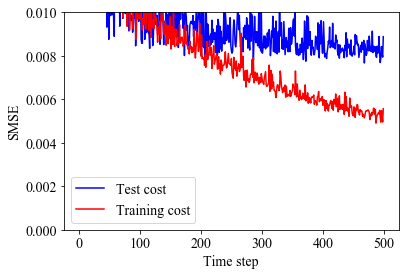

In [118]:
# numpy_loss_history = np.array([history.history['loss'],
#                                history.history['val_loss'],
#                                history.history['mean_squared_error'],
#                                history.history['val_mean_squared_error']
#                               ])
# np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.01])
ax.legend()

In [437]:
model.save('Models/'+model_name+'.h5')
model.save_weights('Models/'+model_name+'_weights.h5')

### State initialization appraoch -- (B)

In [442]:
feature_n_s = np.concatenate((feature_n[:,:2],feature_n[:,5:]),axis=1)
xt_train, xt_test, xf_train, xf_test, y_train, y_test = train_test_split(strains, feature_n_s, y, test_size=0.2)
print(xt_train.shape)
print(xt_test.shape)
print(xf_train.shape)
print(xf_test.shape)
print(y_train.shape)
print(y_test.shape)

(4024, 101, 3)
(1007, 101, 3)
(4024, 4)
(1007, 4)
(4024, 101, 4)
(1007, 101, 4)


In [443]:
model_name = '3_500_leaky_mae_500_statinit'
units = 500
time_span = 101
training_epochs = 500
f_input_dim = xf_train.shape[1]
input_dim = xt_train.shape[2]
output_dim = y_train.shape[2]

In [444]:
LR = LeakyReLU()
LR.__name__ = 'relu'
K.clear_session()

feature_input = Input(shape=(f_input_dim,))
# dense_1_h = Dense(100, activation=LR)(feature_input)
dense_2_h = Dense(units, activation=LR)(feature_input)

series_input = Input(shape=(None, input_dim))
gru1 = GRU(units, return_sequences=True, activation = LR)(series_input, initial_state=dense_2_h)
gru2 = GRU(units, return_sequences=True, activation = LR)(gru1, initial_state=dense_2_h)
gru3 = GRU(units, return_sequences=True, activation = LR)(gru2, initial_state=dense_2_h)

out = TimeDistributed(Dense(output_dim))(gru3)

model = Model(inputs=[feature_input,series_input], outputs=out)
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')

In [445]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 3)      0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          2500        input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, None, 500)    756000      input_2[0][0]                    
                                                                 dense_1[0][0]                    
__________

In [446]:
history = model.fit([xf_train, xt_train], y_train,validation_data=([xf_test, xt_test],y_test), epochs=training_epochs,
          batch_size=64, verbose=1)

Train on 4024 samples, validate on 1007 samples
Epoch 1/500
4024/4024 [==============================] - 28s 7ms/step - loss: 0.1637 - mean_squared_error: 0.0929 - val_loss: 0.1275 - val_mean_squared_error: 0.0825
Epoch 2/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.1042 - mean_squared_error: 0.0644 - val_loss: 0.1046 - val_mean_squared_error: 0.0599
Epoch 3/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0738 - mean_squared_error: 0.0539 - val_loss: 0.0587 - val_mean_squared_error: 0.0417
Epoch 4/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0562 - mean_squared_error: 0.0339 - val_loss: 0.0532 - val_mean_squared_error: 0.0257
Epoch 5/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0428 - mean_squared_error: 0.0187 - val_loss: 0.0382 - val_mean_squared_error: 0.0160
Epoch 6/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0346 - mean_squared_error: 0.0111 - val_lo

4024/4024 [==============================] - 26s 7ms/step - loss: 0.0071 - mean_squared_error: 3.0380e-04 - val_loss: 0.0080 - val_mean_squared_error: 6.8947e-04
Epoch 97/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0074 - mean_squared_error: 3.1012e-04 - val_loss: 0.0060 - val_mean_squared_error: 3.5365e-04
Epoch 98/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0071 - mean_squared_error: 3.2804e-04 - val_loss: 0.0093 - val_mean_squared_error: 5.6261e-04
Epoch 99/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0073 - mean_squared_error: 2.7457e-04 - val_loss: 0.0072 - val_mean_squared_error: 4.4624e-04
Epoch 100/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0071 - mean_squared_error: 2.4238e-04 - val_loss: 0.0079 - val_mean_squared_error: 3.8978e-04
Epoch 101/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0063 - mean_squared_error: 2.2474e-04 - val_loss: 0.008

4024/4024 [==============================] - 26s 7ms/step - loss: 0.0049 - mean_squared_error: 1.4595e-04 - val_loss: 0.0080 - val_mean_squared_error: 4.8539e-04
Epoch 189/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0057 - mean_squared_error: 1.7710e-04 - val_loss: 0.0052 - val_mean_squared_error: 3.6679e-04
Epoch 190/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0054 - mean_squared_error: 1.5607e-04 - val_loss: 0.0077 - val_mean_squared_error: 4.2868e-04
Epoch 191/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0054 - mean_squared_error: 1.5202e-04 - val_loss: 0.0091 - val_mean_squared_error: 7.9357e-04
Epoch 192/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0056 - mean_squared_error: 1.9557e-04 - val_loss: 0.0061 - val_mean_squared_error: 4.2463e-04
Epoch 193/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0047 - mean_squared_error: 1.1850e-04 - val_loss: 0.

4024/4024 [==============================] - 26s 7ms/step - loss: 0.0044 - mean_squared_error: 1.0860e-04 - val_loss: 0.0045 - val_mean_squared_error: 3.6872e-04
Epoch 281/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0045 - mean_squared_error: 1.1130e-04 - val_loss: 0.0052 - val_mean_squared_error: 4.3947e-04
Epoch 282/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0043 - mean_squared_error: 1.0129e-04 - val_loss: 0.0043 - val_mean_squared_error: 2.7311e-04
Epoch 283/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0044 - mean_squared_error: 1.0053e-04 - val_loss: 0.0041 - val_mean_squared_error: 3.2917e-04
Epoch 284/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0037 - mean_squared_error: 7.3418e-05 - val_loss: 0.0050 - val_mean_squared_error: 3.6893e-04
Epoch 285/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0039 - mean_squared_error: 6.9032e-05 - val_loss: 0.

4024/4024 [==============================] - 26s 7ms/step - loss: 0.0037 - mean_squared_error: 5.7454e-05 - val_loss: 0.0051 - val_mean_squared_error: 4.8331e-04
Epoch 373/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0040 - mean_squared_error: 8.0246e-05 - val_loss: 0.0041 - val_mean_squared_error: 4.1745e-04
Epoch 374/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0038 - mean_squared_error: 6.7895e-05 - val_loss: 0.0048 - val_mean_squared_error: 3.3113e-04
Epoch 375/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0033 - mean_squared_error: 5.5302e-05 - val_loss: 0.0048 - val_mean_squared_error: 3.0934e-04
Epoch 376/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0042 - mean_squared_error: 9.8485e-05 - val_loss: 0.0035 - val_mean_squared_error: 2.9413e-04
Epoch 377/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0040 - mean_squared_error: 8.1249e-05 - val_loss: 0.

4024/4024 [==============================] - 26s 7ms/step - loss: 0.0040 - mean_squared_error: 6.7937e-05 - val_loss: 0.0040 - val_mean_squared_error: 3.6350e-04
Epoch 465/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0033 - mean_squared_error: 5.1156e-05 - val_loss: 0.0035 - val_mean_squared_error: 3.4685e-04
Epoch 466/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0033 - mean_squared_error: 5.3738e-05 - val_loss: 0.0049 - val_mean_squared_error: 4.9070e-04
Epoch 467/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0035 - mean_squared_error: 5.9701e-05 - val_loss: 0.0034 - val_mean_squared_error: 4.1527e-04
Epoch 468/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0040 - mean_squared_error: 6.8053e-05 - val_loss: 0.0053 - val_mean_squared_error: 2.8253e-04
Epoch 469/500
4024/4024 [==============================] - 26s 7ms/step - loss: 0.0036 - mean_squared_error: 5.7523e-05 - val_loss: 0.

In [329]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict([xf_train, xt_train])
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict([xf_test, xt_test])
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())

SRMSE for train-set
0.007101093380212008
SRMSE for test-set
0.012435781874193879
SMAE for train-set
0.0033055165028995715
SMAE for test-set
0.0035732193732525056
Scaled mean max plastic energy decrease for train-set
0.013071868689240106
Scaled mean max plastic energy decrease for test-set
0.014411729440470379


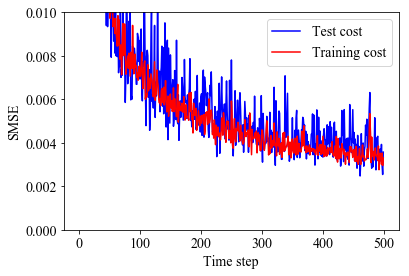

In [331]:
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.01])
ax.legend()

In [333]:
model.save('Models/'+model_name+'.h5')
model.save_weights('Models/'+model_name+'_weights.h5')

/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer gru_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'dense_2/leaky_re_lu_1/LeakyRelu:0' shape=(?, 500) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer gru_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'dense_2/leaky_re_lu_1/LeakyRelu:0' shape=(?, 500) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer gru_3 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'dense_2/leaky_re_lu_1/LeakyRelu:0

### Mixed GRU -- C

In [ ]:
class CGRUCell(Layer):
    """Custom cell class for the GRU layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hard sigmoid (`hard_sigmoid`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        reset_after: GRU convention (whether to apply reset gate after or
            before matrix multiplication). False = "before" (default),
            True = "after" (CuDNN compatible).
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='hard_sigmoid',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 reset_after=False,
                 **kwargs):
        super(GRUCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.reset_after = reset_after
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 3),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 3),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            if not self.reset_after:
                bias_shape = (3 * self.units,)
            else:
                # separate biases for input and recurrent kernels
                # Note: the shape is intentionally different from CuDNNGRU biases
                # `(2 * 3 * self.units,)`, so that we can distinguish the classes
                # when loading and converting saved weights.
                bias_shape = (2, 3 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            if not self.reset_after:
                self.input_bias, self.recurrent_bias = self.bias, None
            else:
                # NOTE: need to flatten, since slicing in CNTK gives 2D array
                self.input_bias = K.flatten(self.bias[0])
                self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # update gate
        self.kernel_z = self.kernel[:, :self.units]
        self.recurrent_kernel_z = self.recurrent_kernel[:, :self.units]
        # reset gate
        self.kernel_r = self.kernel[:, self.units: self.units * 2]
        self.recurrent_kernel_r = self.recurrent_kernel[:,
                                                        self.units:
                                                        self.units * 2]
        # new gate
        self.kernel_h = self.kernel[:, self.units * 2:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units * 2:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_z = self.input_bias[:self.units]
            self.input_bias_r = self.input_bias[self.units: self.units * 2]
            self.input_bias_h = self.input_bias[self.units * 2:]
            # bias for hidden state - just for compatibility with CuDNN
            if self.reset_after:
                self.recurrent_bias_z = self.recurrent_bias[:self.units]
                self.recurrent_bias_r = (
                    self.recurrent_bias[self.units: self.units * 2])
                self.recurrent_bias_h = self.recurrent_bias[self.units * 2:]
        else:
            self.input_bias_z = None
            self.input_bias_r = None
            self.input_bias_h = None
            if self.reset_after:
                self.recurrent_bias_z = None
                self.recurrent_bias_r = None
                self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=3)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_z = inputs * dp_mask[0]
                inputs_r = inputs * dp_mask[1]
                inputs_h = inputs * dp_mask[2]
            else:
                inputs_z = inputs
                inputs_r = inputs
                inputs_h = inputs

            x_z = K.dot(inputs_z, self.kernel_z)
            x_r = K.dot(inputs_r, self.kernel_r)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_z = K.bias_add(x_z, self.input_bias_z)
                x_r = K.bias_add(x_r, self.input_bias_r)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_z = h_tm1 * rec_dp_mask[0]
                h_tm1_r = h_tm1 * rec_dp_mask[1]
                h_tm1_h = h_tm1 * rec_dp_mask[2]
            else:
                h_tm1_z = h_tm1
                h_tm1_r = h_tm1
                h_tm1_h = h_tm1

            recurrent_z = K.dot(h_tm1_z, self.recurrent_kernel_z)
            recurrent_r = K.dot(h_tm1_r, self.recurrent_kernel_r)
            if self.reset_after and self.use_bias:
                recurrent_z = K.bias_add(recurrent_z, self.recurrent_bias_z)
                recurrent_r = K.bias_add(recurrent_r, self.recurrent_bias_r)

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            # reset gate applied after/before matrix multiplication
            if self.reset_after:
                recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
                if self.use_bias:
                    recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
                recurrent_h = r * recurrent_h
            else:
                recurrent_h = K.dot(r * h_tm1_h, self.recurrent_kernel_h)

            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_z = matrix_x[:, :self.units]
            x_r = matrix_x[:, self.units: 2 * self.units]
            x_h = matrix_x[:, 2 * self.units:]

            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            if self.reset_after:
                # hidden state projected by all gate matrices at once
                matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
                if self.use_bias:
                    matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            else:
                # hidden state projected separately for update/reset and new
                matrix_inner = K.dot(h_tm1,
                                     self.recurrent_kernel[:, :2 * self.units])

            recurrent_z = matrix_inner[:, :self.units]
            recurrent_r = matrix_inner[:, self.units: 2 * self.units]

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            if self.reset_after:
                recurrent_h = r * matrix_inner[:, 2 * self.units:]
            else:
                recurrent_h = K.dot(r * h_tm1,
                                    self.recurrent_kernel[:, 2 * self.units:])

            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = z * h_tm1 + (1 - z) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation,
                  'reset_after': self.reset_after}
        base_config = super(GRUCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### RNN architecture analysis

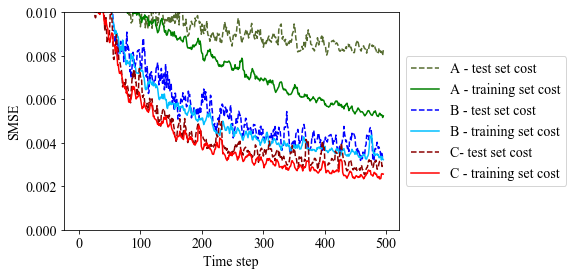

In [164]:
model_name_a = '3_500_leaky_mae_500_densemix'
model_name_b = '3_500_leaky_mae_500_statinit'
model_name_c = '3_500_leaky_mae_500'

numpy_loss_history_a = np.loadtxt('Models/'+model_name_a+'_loss_history.txt', delimiter=",")
numpy_loss_history_b = np.loadtxt('Models/'+model_name_b+'_loss_history.txt', delimiter=",")
numpy_loss_history_c = np.loadtxt('Models/'+model_name_c+'_loss_history.txt', delimiter=",")

N = 5
markevery = 100
train_a = np.convolve(numpy_loss_history_a[0,:], np.ones((N,))/N, mode='valid')
test_a = np.convolve(numpy_loss_history_a[1,:], np.ones((N,))/N, mode='valid') 

train_b = np.convolve(numpy_loss_history_b[0,:], np.ones((N,))/N, mode='valid')
test_b = np.convolve(numpy_loss_history_b[1,:], np.ones((N,))/N, mode='valid') 

train_c = np.convolve(numpy_loss_history_c[0,:], np.ones((N,))/N, mode='valid')
test_c = np.convolve(numpy_loss_history_c[1,:], np.ones((N,))/N, mode='valid') 

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(test_a,'darkolivegreen', linestyle = '--', label = 'A - test set cost')
ax.plot(train_a,'g', label = 'A - training set cost')

ax.plot(test_b,'b', linestyle = '--', label = 'B - test set cost')
ax.plot(train_b,'deepskyblue', label = 'B - training set cost')

ax.plot(test_c,'darkred', linestyle = '--', label = 'C- test set cost')
ax.plot(train_c,'r', label = 'C - training set cost')

ax.set(xlabel='Training epochs', ylabel='SMSE')
ax.set_ylim([0.0, 0.01])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [165]:
fig.savefig('architecture_ana.svg', format='svg', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('architecture_ana.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')

## Investigate the influence of non-temporal features

In [46]:
# load model in case of leaky Relu
model_name = '3_500'
# model_name = '3_500_leaky_mae_500_2'
LR = LeakyReLU()
LR.__name__ = 'relu'
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR))
model.add(GRU(units, return_sequences=True, activation = LR))
model.add(GRU(units, return_sequences=True, activation = LR))
model.add(TimeDistributed(Dense(output_dim)))
model.output_shape

model.load_weights('Models/'+model_name+'_weights.h5')
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')

/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


3_500
Load path sample number: 454
Mircostructure 1 sample number 1576, fill ratio: 11.70, particle size: 6.86, mean distance: 11.51, std distance: 3.75

Mircostructure 2 sample number 1292, fill ratio: 35.44, particle size: 8.81, mean distance: 5.89, std distance: 0.65



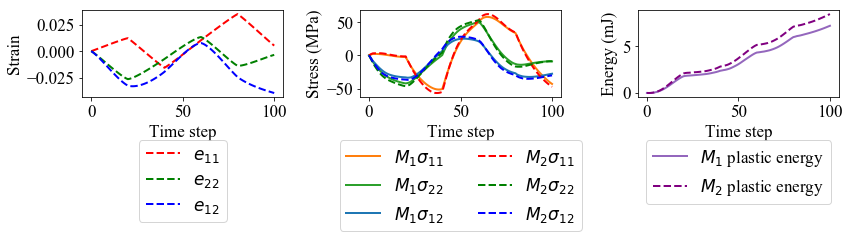

In [256]:
# model_name = '3_500_1'
print(model_name)
# model_loaded = load_model('Models/'+model_name+'.h5')
test_sample=np.random.randint(y_test.shape[0])
# test_sample = 491
x_input = x_test[test_sample,:,:].reshape(1,101,input_dim)

test_sample_1=np.random.randint(y_test.shape[0])
#feature_input_1 = np.expand_dims(np.zeros((1,4)),axis =1)
#feature_input_1 = np.repeat(feature_input_1, 101, axis=1)
feature_input_1 = x_test[test_sample_1,:,:7].reshape(1,101,7)
x_input_1 = np.concatenate((feature_input_1, x_input[:,:,7:]), axis=2)

test_sample_2=np.random.randint(y_test.shape[0])
feature_input_2 = x_test[test_sample_2,:,:7].reshape(1,101,7)
# feature_input_2 = np.expand_dims(np.ones((1,4)),axis =1)
# feature_input_2 = np.repeat(feature_input_2, 101, axis=1)
x_input_2 = np.concatenate((feature_input_2, x_input[:,:,7:]), axis=2)

ypred_1 = model.predict(x_input_1)
ypred_2 = model.predict(x_input_2)

y_pred_s_1 = sc_s.inverse_transform(ypred_1[:,:,1:].reshape(-1,1))
y_pred_s_1 = y_pred_s_1.reshape((101,3))
y_pred_e_1 = sc_e.inverse_transform(ypred_1[:,:,0].reshape(-1,1))
y_pred_e_1 = y_pred_e_1.reshape((101,1))

y_pred_s_2 = sc_s.inverse_transform(ypred_2[:,:,1:].reshape(-1,1))
y_pred_s_2 = y_pred_s_2.reshape((101,3))
y_pred_e_2 = sc_e.inverse_transform(ypred_2[:,:,0].reshape(-1,1))
y_pred_e_2 = y_pred_e_2.reshape((101,1))

x_test_sr = sc_st.inverse_transform(x_test[test_sample,:,7:].reshape(-1,1))
x_test_sr = x_test_sr.reshape((101,3))

print('Load path sample number: '+str(test_sample))

x_test_f_1 = sc_f.inverse_transform(feature_input_1[:,0,:].reshape(-1,7))
x_test_f_1 = x_test_f_1.reshape((7))

print("Mircostructure 1 sample number %d, fill ratio: %.2f, particle size: %.2f, mean distance: %.2f, std distance: %.2f\n"
                     % (test_sample_1,
                        x_test_f_1[0],
                        x_test_f_1[1],
                        x_test_f_1[5],
                        x_test_f_1[6]))

x_test_f_2 = sc_f.inverse_transform(feature_input_2[:,0,:].reshape(-1,7))
x_test_f_2 = x_test_f_2.reshape((7))

print("Mircostructure 2 sample number %d, fill ratio: %.2f, particle size: %.2f, mean distance: %.2f, std distance: %.2f\n"
                     % (test_sample_2,
                        x_test_f_2[0],
                        x_test_f_2[1],
                        x_test_f_2[5],
                        x_test_f_2[6]))


matplotlib.rcParams.update({'font.size': 17})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12.0, 4.5))
ax1.plot(x_test_sr[:,0],'r',linestyle = '--', linewidth=2,label="$e_{11}$")
ax1.plot(x_test_sr[:,1],'g',linestyle = '--', linewidth=2,label="$e_{22}$")
ax1.plot(x_test_sr[:,2],'b',linestyle = '--', linewidth=2,label="$e_{12}$")

ax1.set(xlabel='Time step', ylabel='Strain')
lgd1 = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

ax2.plot(y_pred_s_1[:,0],'C1',linewidth=2,label="$M_1 \sigma_{11}$")
ax2.plot(y_pred_s_1[:,1],'C2',linewidth=2,label="$M_1 \sigma_{22}$")
ax2.plot(y_pred_s_1[:,2],'C0',linewidth=2,label="$M_1 \sigma_{12}$")

ax2.plot(y_pred_s_2[:,0],'r',linestyle = '--',linewidth=2,label="$M_2 \sigma_{11}$")
ax2.plot(y_pred_s_2[:,1],'g',linestyle = '--',linewidth=2,label="$M_2 \sigma_{22}$")
ax2.plot(y_pred_s_2[:,2],'b',linestyle = '--',linewidth=2,label="$M_2 \sigma_{12}$")

ax2.set(xlabel='Time step', ylabel='Stress (MPa)')
lgd2 = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

ax3.plot(y_pred_e_1[:,0],'C4',linewidth=2, label="$M_1$ plastic energy")

ax3.plot(y_pred_e_2[:,0],'purple',linestyle = '--',linewidth=2, label="$M_2$ plastic energy")


ax3.set(xlabel='Time step', ylabel='Energy (mJ)')
lgd3 = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

fig.tight_layout()

In [257]:
fig.savefig('micro_compare_1.svg', format='svg', dpi=1200, bbox_extra_artists=(lgd1,lgd2,lgd3), bbox_inches='tight')
fig.savefig('micro_compare_1.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd1,lgd2,lgd3), bbox_inches='tight')